In [5]:
include("astrobee_se3_script.jl")
using Plots

N = 30
dimLinearConstraintsU = 0
dimSecondOrderConeConstraintsU = 0
MAX_ITERATIONS_NB = 100

model = AstrobeeSE3()

Xp,Up = initialize_trajectory(model, N)
X, U  = copy(Xp), copy(Up)

SCPproblem = GuSTOProblem(model, N, dimLinearConstraintsU, dimSecondOrderConeConstraintsU, Xp, Up)

x_dim, u_dim = model.x_dim, model.u_dim

Delta0, omega0, omegamax, 
epsilon, rho0, rho1, 
beta_succ, beta_fail, gamma_fail, 
convergence_threshold = get_initial_gusto_parameters(model)

Delta = Delta0
omega = omega0

1.0

In [6]:
X_all, U_all, x_shooting_all = [], [], []
push!(X_all, copy(X))
push!(U_all, copy(U))

B_success = false
it = 0

while it<MAX_ITERATIONS_NB && 
        !(B_success &&
            convergence_metric(model,X,U,Xp,Up)<convergence_threshold) &&
        omega<omegamax
    println("-----------")
    println("Iteration $it")
    println("-----------")
    
    Xp = copy(X)
    Up = copy(U)
    
    model.f, model.A, model.B = compute_dynamics(model, Xp, Up)
    
    reset_problem(SCPproblem, model)
    set_parameters(SCPproblem, model, Xp, Up, omega, Delta)
    define_cost(SCPproblem, model)
    define_constraints(SCPproblem, model)
    
    JuMP.optimize!(SCPproblem.solver_model)
    X_sol = JuMP.value.(SCPproblem.X)
    U_sol = JuMP.value.(SCPproblem.U)
    
    # GuSTO Logic
    if it > 0
        if is_in_trust_region(model, X_sol, U_sol, Xp, Up, Delta)
            rho = accuracy_ratio(SCPproblem, model, X_sol, U_sol, Xp, Up)

            if rho > rho1
                println("Reject solution.")
                Delta = beta_fail * Delta
                omega     = omega
                B_success = false

            else
                println("Accept solution.")
                X = copy(X_sol)
                U = copy(U_sol)
                B_success = true
                if rho < rho0
                    Delta = min(beta_succ*Delta, Delta0)
                else
                    Delta = Delta
                end
                if satisfies_state_inequality_constraints(SCPproblem, model, X_sol, U_sol, Xp, Up, Delta)
                    omega = omega0
                else
                    println("Solution does not satisfy state constraints, increasing omega.")
                    omega = gamma_fail * omega
                    B_success = false
                end
            end

        else
            println("Reject solution (Outside trust region)")
            Delta = Delta
            omega     = gamma_fail * omega
            B_success = false
        end
    else
        X = copy(X_sol)
        U = copy(U_sol)
    end

    push!(X_all, copy(X))
    push!(U_all, copy(U))       
    
    it += 1
    
    println("Parameters:")
    println("omega=$omega")
    println("delta=$Delta")
    println("metric=$(convergence_metric(model,X,U,Xp,Up))")
    println(" ")
end


-----------
Iteration 0
-----------
Parameters:
omega=1.0
delta=1000.0
metric=21.61730651184242
 
-----------
Iteration 1
-----------
Accept solution.
Parameters:
omega=1.0
delta=1000.0
metric=15.836596975746438
 
-----------
Iteration 2
-----------
Accept solution.
Solution does not satisfy state constraints, increasing omega.
Parameters:
omega=5.0
delta=1000.0
metric=3.6074427868523564
 
-----------
Iteration 3
-----------
Accept solution.
Parameters:
omega=1.0
delta=1000.0
metric=2.2050894996028965
 


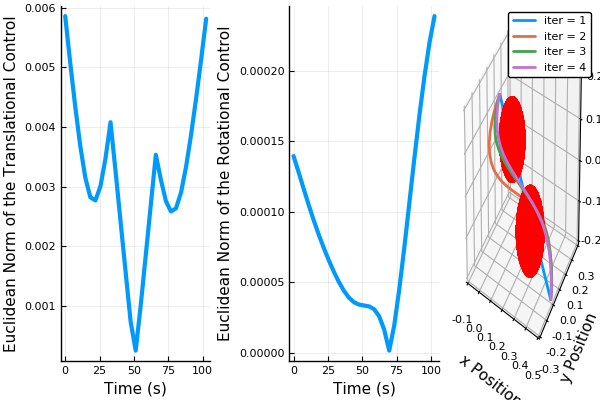

In [7]:
timeSpan = zeros(N)
timeSpanControl = zeros(N-1)
constraint = zeros(N)
constraint[1] = obstacle_constraint(model,X_all[end],U_all[end],X_all[end-1],U_all[end-1],1,1)
control1 = zeros(N-1)
control2 = zeros(N-1)
for i = 1:N-1
    timeSpan[i+1] = timeSpan[i] + model.tf/N
    if i < N-1
        timeSpanControl[i+1] = timeSpan[i] + model.tf/N
    end
    constraint[i+1] = obstacle_constraint(model,X_all[end],U_all[end],X_all[end-1],U_all[end-1],i,1)
    control1[i] = norm(U_all[end][1:3,i])
    control2[i] = norm(U_all[end][4:6,i])
end
#plot(timeSpan,constraint,linewidth=3,label="")
p1 = plot(timeSpanControl,control1,linewidth=3,label="",xlabel="Time (s)",ylabel="Euclidean Norm of the Translational Control")
p2 = plot(timeSpanControl,control2,linewidth=3,label="",xlabel="Time (s)",ylabel="Euclidean Norm of the Rotational Control")
#ylims=(-0.001,0.0075)
#plot_solutions(SCPproblem, model, X_all[end-1:end], U_all[end-1:end]; x_shooting_all=x_shooting_all)

p3 = plot3D_solutions(SCPproblem, model, X_all[1:end-1], U_all[1:end-1])

plot(p1,p2,p3,layout=(1,3))